In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [17]:
import numpy as np

def pad_list(lc, nepochs, dict_info):
    pad_num = dict_info['window_size'] - nepochs
    if pad_num >= 0:
        # Si el tamaño de la lista es menor que window_size, rellena con ceros
        return np.pad(lc, (0, pad_num), 'constant', constant_values=(0, 0))
    else:
        # Genera índices espaciados logarítmicamente
        indices = np.logspace(start=np.log10(1), stop=np.log10(nepochs), num=dict_info['window_size'], endpoint=True, base=10) - 1
        indices = np.unique(np.round(indices).astype(int))
        indices = np.clip(indices, 0, nepochs-1)
        return np.array(lc)[indices]

# Ejemplo de uso:
lc = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nepochs = len(lc)
dict_info = {'window_size': 15}

resultado = pad_list(lc, nepochs, dict_info)
print(resultado)

[ 0  1  2  3  4  5  6  7  8  9 10  0  0  0  0]


In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_windows_200'
path_results = './results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_windows/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/partitions/v3/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18adldhip',
 'aid_ZTF19aasbgeb',
 'aid_ZTF18aayfbqd',
 'aid_ZTF19ablyzbl',
 'aid_ZTF18actabfv',
 'aid_ZTF18aaztkvq',
 'aid_ZTF21aaphzsw',
 'aid_ZTF19aarhrcv',
 'aid_ZTF17aaajmxw',
 'aid_ZTF18acrvact',
 'aid_ZTF22aaahdyl',
 'aid_ZTF18aacebav',
 'aid_ZTF19abnqhwd',
 'aid_ZTF19abjgdow',
 'aid_ZTF18abklljv',
 'aid_ZTF18aalaphh',
 'aid_ZTF23aaaziou',
 'aid_ZTF17aacihzd',
 'aid_ZTF22abnmzar',
 'aid_ZTF17aaaoite',
 'aid_ZTF18abcurfb',
 'aid_ZTF18adbbyzu',
 'aid_ZTF18aaxpqts',
 'aid_ZTF18aacgwxk',
 'aid_ZTF18admcecv',
 'aid_ZTF18abukrnx',
 'aid_ZTF19aapuibt',
 'aid_ZTF18aawccep',
 'aid_ZTF21aahfpup',
 'aid_ZTF19aaoztzf',
 'aid_ZTF18aayijfg',
 'aid_ZTF18abgpcbj',
 'aid_ZTF18abwbiev',
 'aid_ZTF18actawil',
 'aid_ZTF20abyzomt',
 'aid_ZTF17aabxqbf',
 'aid_ZTF18abukymf',
 'aid_ZTF18abvbsoc',
 'aid_ZTF18actunfi',
 'aid_ZTF18aazfeau',
 'aid_ZTF22aaayewi',
 'aid_ZTF18aaxtcdl',
 'aid_ZTF18abtoxjw',
 'aid_ZTF18acdpxfb',
 'aid_ZTF18aabvmax',
 'aid_ZTF18abbogne',
 'aid_ZTF18aapnlus',
 'aid_ZTF18ab

In [6]:
y_real_test.shape

(8346,)

In [7]:
len(obj_label)

8346

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [10]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([10, 10, 10,  ...,  4,  4,  4]),
 'list_y_pred': {'test_16': array([ 2,  2,  2, ..., 16, 16, 16]),
  'test_32': array([10, 10, 10, ..., 16, 16, 16]),
  'test_64': array([10, 10, 10, ..., 16, 16,  4]),
  'test_128': array([10, 10, 10, ..., 16, 16,  4]),
  'test_256': array([10, 10, 10, ..., 16, 16,  4]),
  'test_512': array([10, 10, 10, ..., 16, 16,  4]),
  'test_1024': array([10, 10, 10, ..., 16, 16,  4]),
  'test_2048': array([10, 10, 10, ...,  4,  4,  4])},
 'list_y_pred_prob': {'test_16': array([[3.6222719e-08, 2.7924095e-08, 9.7187668e-01, ..., 1.8353014e-14,
          2.1992568e-09, 3.1646664e-12],
         [1.1936895e-07, 6.4801313e-08, 9.0987587e-01, ..., 6.7129408e-14,
          4.0006555e-08, 8.9388375e-12],
         [8.8252079e-08, 4.6659107e-08, 9.0283567e-01, ..., 9.3514367e-13,
          2.80

In [11]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41728
length:  41728


In [12]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [13]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 2, 11,  5, ...,  4,  4, 16]),
 'test_32': array([10, 11,  5, ...,  4,  4, 16]),
 'test_64': array([10, 11,  5, ...,  9,  4, 16]),
 'test_128': array([10, 11,  5, ..., 20,  4, 16]),
 'test_256': array([10, 11,  5, ..., 20,  4, 16]),
 'test_512': array([10, 11,  5, ..., 20,  4, 16]),
 'test_1024': array([10, 11,  5, ..., 20,  4, 16]),
 'test_2048': array([10, 11,  5, ..., 20,  4,  4])}

In [14]:
predictions['list_y_pred_avg']['test_2048'].shape

(41728,)

In [15]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [16]:
predictions['y_test'].shape

torch.Size([252810])

In [17]:
predictions['SNID'].shape

(252810,)

In [18]:
print(idx_unique_y_test)

[0, 8, 16, 21, 30, 38, 46, 54, 57, 62, 67, 74, 80, 84, 96, 101, 106, 113, 119, 124, 128, 132, 139, 144, 155, 164, 168, 177, 189, 200, 209, 218, 227, 235, 245, 255, 263, 271, 279, 288, 295, 304, 310, 314, 319, 320, 325, 330, 334, 338, 341, 347, 354, 363, 370, 377, 384, 392, 395, 402, 408, 415, 422, 430, 438, 445, 453, 462, 472, 479, 488, 494, 500, 504, 511, 515, 530, 543, 548, 554, 561, 572, 585, 597, 610, 622, 635, 642, 654, 662, 671, 678, 693, 706, 713, 719, 724, 734, 742, 746, 756, 772, 781, 788, 794, 802, 811, 819, 826, 835, 843, 847, 859, 867, 879, 894, 898, 907, 915, 922, 930, 939, 946, 953, 961, 970, 979, 988, 997, 1009, 1012, 1019, 1031, 1040, 1051, 1059, 1066, 1074, 1081, 1090, 1097, 1101, 1109, 1117, 1128, 1133, 1140, 1152, 1163, 1170, 1181, 1184, 1192, 1199, 1207, 1211, 1221, 1234, 1241, 1251, 1260, 1267, 1277, 1281, 1289, 1295, 1304, 1310, 1318, 1324, 1328, 1332, 1338, 1350, 1356, 1361, 1368, 1375, 1384, 1392, 1398, 1405, 1413, 1418, 1426, 1434, 1446, 1453, 1459, 1465, 1473,

In [19]:
print(ids_unique_real)

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [20]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41728])


,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing,shorten
aid_ZTF17aaaecgi,2.494511e-07,1.061254e-07,8.567269e-01,1.531415e-02,7.567024e-07,5.957780e-05,3.357311e-03,2.518957e-05,2.547483e-07,2.702047e-10,...,7.708868e-05,5.636164e-09,1.070875e-03,1.076524e-10,7.280640e-13,7.312970e-10,5.774619e-12,5.682171e-08,4.126349e-11,16
aid_ZTF17aaaedvi,6.001066e-10,8.639608e-11,1.626394e-06,8.525866e-04,1.568923e-08,2.593862e-05,1.644494e-07,6.696330e-08,3.304123e-09,3.799770e-08,...,1.121583e-05,5.712769e-10,2.382356e-06,2.816312e-11,5.278248e-12,5.677675e-12,3.360162e-15,2.478068e-10,9.554988e-11,16
aid_ZTF17aaafglk,3.817087e-07,3.041553e-05,5.387800e-03,1.429199e-04,1.017701e-06,9.694060e-01,2.896592e-03,2.672252e-04,5.086823e-04,7.528447e-08,...,2.419619e-03,6.431740e-04,4.867523e-03,3.061534e-09,1.451472e-12,6.085505e-12,3.675582e-08,8.580563e-11,5.706683e-13,16
aid_ZTF17aaafiut,7.663547e-08,3.885249e-07,8.747362e-01,1.025022e-03,2.135102e-06,3.373060e-05,2.791938e-02,2.181171e-03,2.687102e-08,9.187441e-09,...,8.382264e-04,1.222737e-07,1.407894e-02,1.068843e-08,4.639675e-11,9.587331e-10,2.365660e-11,1.786338e-07,2.613717e-11,16
aid_ZTF17aaafiww,3.121853e-07,4.628779e-07,6.713864e-01,3.128391e-02,7.339007e-06,2.992443e-03,2.709081e-02,6.777303e-03,2.496903e-07,1.612418e-09,...,6.713354e-04,9.720457e-08,7.759615e-02,4.613840e-10,5.280235e-12,1.231322e-09,2.700525e-12,2.151531e-08,1.421148e-11,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,5.681292e-08,3.007194e-08,1.953694e-04,2.084331e-07,6.125374e-08,8.005567e-06,6.114992e-05,3.480779e-04,2.484468e-10,4.467418e-09,...,1.617587e-06,9.980050e-01,3.825650e-04,1.937121e-09,4.650431e-12,1.020994e-10,1.195967e-10,5.946829e-11,8.606886e-15,2048
aid_ZTF23aamsarj,2.295181e-09,1.234211e-08,1.888055e-10,8.626128e-11,8.396411e-01,2.043533e-05,2.145834e-09,2.339956e-10,1.043831e-11,1.481378e-01,...,6.328067e-08,1.220711e-14,4.391813e-11,1.173041e-02,1.649642e-12,9.318966e-19,7.086101e-06,4.630893e-04,3.802121e-15,2048
aid_ZTF23aamxeoe,6.102429e-09,9.602551e-10,8.723391e-12,1.646276e-09,2.041789e-03,1.242649e-08,5.688460e-12,4.074827e-10,4.233541e-09,7.399146e-05,...,3.515292e-11,3.861122e-16,1.674889e-12,3.483507e-06,8.341568e-10,9.911050e-07,3.387106e-17,9.978799e-01,3.936090e-12,2048
aid_ZTF23aavxvsz,3.824595e-08,2.114332e-10,7.565773e-11,4.731474e-11,9.999630e-01,8.669680e-08,1.021601e-12,6.147906e-08,6.972525e-10,3.039086e-05,...,5.724581e-11,7.588885e-16,3.963029e-13,6.436614e-06,1.915304e-12,2.458063e-13,7.311985e-16,2.454303e-13,1.885520e-13,2048


In [21]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
aid_ZTF18adldhip,6.353377e-01,3.515915e-01,5.388068e-10,1.166085e-07,2.683993e-07,2.837487e-06,1.026353e-07,4.351594e-07,1.306563e-02,6.744371e-07,...,5.879333e-10,2.488771e-08,6.301510e-07,7.669701e-09,3.454449e-15,1.271894e-08,6.445034e-14,8.887722e-15,3.492154e-08,5.771034e-16
aid_ZTF19aasbgeb,8.296058e-03,9.901168e-01,1.093715e-09,1.070688e-09,5.205337e-09,1.375080e-07,7.172254e-07,2.466132e-08,1.585914e-03,3.522720e-08,...,1.274890e-10,5.442229e-08,2.705304e-07,2.737246e-09,2.152238e-17,3.575644e-09,6.961760e-17,2.414928e-18,2.450649e-11,3.187783e-16
aid_ZTF18aayfbqd,6.574119e-09,1.564456e-09,2.436579e-01,6.471508e-02,2.900639e-06,2.529884e-05,7.914057e-05,4.295298e-07,7.785665e-09,3.978379e-09,...,7.627602e-03,4.736228e-04,1.389307e-11,8.180748e-04,9.800040e-12,1.126807e-13,1.603607e-11,1.672407e-15,9.385857e-10,2.534621e-09
aid_ZTF19ablyzbl,1.649142e-03,9.982947e-01,1.448247e-07,2.524130e-08,3.499978e-08,1.007801e-05,5.004822e-06,6.153168e-07,2.178034e-05,2.727038e-08,...,3.846387e-09,1.482353e-06,1.646473e-05,1.620326e-08,2.600702e-17,4.955517e-09,1.056357e-16,1.153671e-16,7.253995e-08,9.261814e-17
aid_ZTF18actabfv,1.331585e-07,3.850146e-07,8.647091e-05,9.403785e-01,4.056014e-10,3.847784e-05,4.588532e-05,5.027929e-02,1.980261e-07,1.109248e-10,...,1.074256e-04,6.894950e-07,8.914744e-03,3.734823e-05,1.786733e-13,3.963555e-17,2.823167e-15,8.338118e-16,1.243689e-14,3.072783e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abdlmwe,5.743783e-12,1.796869e-12,2.894062e-07,3.901936e-06,1.636895e-09,1.516722e-09,2.937886e-08,2.825387e-06,1.379264e-12,4.199857e-13,...,9.999918e-01,8.672316e-08,2.400493e-12,4.218468e-09,8.179004e-13,8.959860e-17,4.710122e-15,2.334305e-15,3.089953e-17,3.806433e-13
aid_ZTF18abnueof,2.209169e-08,1.807381e-07,2.215194e-07,5.776970e-10,5.927896e-11,1.965416e-07,9.969554e-01,1.965447e-03,1.106025e-09,1.537099e-10,...,3.827430e-04,6.486676e-04,2.870692e-06,7.113584e-07,3.821317e-09,4.398767e-14,4.510225e-14,2.876424e-13,3.057653e-12,3.996423e-16
aid_ZTF17aaagvih,1.408513e-06,1.024284e-06,4.976970e-08,9.956838e-01,6.471190e-09,3.822999e-03,1.876181e-07,5.688502e-05,4.656534e-06,4.187392e-09,...,7.954051e-05,8.286705e-08,4.027114e-06,2.091023e-07,3.797279e-13,1.449704e-18,3.634037e-19,4.523618e-14,6.033608e-08,1.481426e-17
aid_ZTF17aabpjme,9.311734e-12,3.135372e-10,2.682856e-07,6.597881e-10,7.897818e-13,9.562817e-08,4.194980e-04,1.499534e-05,4.997319e-10,2.444425e-12,...,2.643683e-03,9.969200e-01,1.419713e-08,4.090403e-08,3.597539e-07,5.144276e-16,1.578804e-14,2.753509e-14,4.061360e-17,4.267229e-12


In [22]:
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
aid_ZTF18adldhip,6.353377e-01,3.515915e-01,5.388068e-10,1.166085e-07,2.683993e-07,2.837487e-06,1.026353e-07,4.351594e-07,1.306563e-02,6.744371e-07,...,5.879333e-10,2.488771e-08,6.301510e-07,7.669701e-09,3.454449e-15,1.271894e-08,6.445034e-14,8.887722e-15,3.492154e-08,5.771034e-16
aid_ZTF19aasbgeb,8.296058e-03,9.901168e-01,1.093715e-09,1.070688e-09,5.205337e-09,1.375080e-07,7.172254e-07,2.466132e-08,1.585914e-03,3.522720e-08,...,1.274890e-10,5.442229e-08,2.705304e-07,2.737246e-09,2.152238e-17,3.575644e-09,6.961760e-17,2.414928e-18,2.450649e-11,3.187783e-16
aid_ZTF18aayfbqd,6.574119e-09,1.564456e-09,2.436579e-01,6.471508e-02,2.900639e-06,2.529884e-05,7.914057e-05,4.295298e-07,7.785665e-09,3.978379e-09,...,7.627602e-03,4.736228e-04,1.389307e-11,8.180748e-04,9.800040e-12,1.126807e-13,1.603607e-11,1.672407e-15,9.385857e-10,2.534621e-09
aid_ZTF19ablyzbl,1.649142e-03,9.982947e-01,1.448247e-07,2.524130e-08,3.499978e-08,1.007801e-05,5.004822e-06,6.153168e-07,2.178034e-05,2.727038e-08,...,3.846387e-09,1.482353e-06,1.646473e-05,1.620326e-08,2.600702e-17,4.955517e-09,1.056357e-16,1.153671e-16,7.253995e-08,9.261814e-17
aid_ZTF18actabfv,1.331585e-07,3.850146e-07,8.647091e-05,9.403785e-01,4.056014e-10,3.847784e-05,4.588532e-05,5.027929e-02,1.980261e-07,1.109248e-10,...,1.074256e-04,6.894950e-07,8.914744e-03,3.734823e-05,1.786733e-13,3.963555e-17,2.823167e-15,8.338118e-16,1.243689e-14,3.072783e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abdlmwe,5.743783e-12,1.796869e-12,2.894062e-07,3.901936e-06,1.636895e-09,1.516722e-09,2.937886e-08,2.825387e-06,1.379264e-12,4.199857e-13,...,9.999918e-01,8.672316e-08,2.400493e-12,4.218468e-09,8.179004e-13,8.959860e-17,4.710122e-15,2.334305e-15,3.089953e-17,3.806433e-13
aid_ZTF18abnueof,2.209169e-08,1.807381e-07,2.215194e-07,5.776970e-10,5.927896e-11,1.965416e-07,9.969554e-01,1.965447e-03,1.106025e-09,1.537099e-10,...,3.827430e-04,6.486676e-04,2.870692e-06,7.113584e-07,3.821317e-09,4.398767e-14,4.510225e-14,2.876424e-13,3.057653e-12,3.996423e-16
aid_ZTF17aaagvih,1.408513e-06,1.024284e-06,4.976970e-08,9.956838e-01,6.471190e-09,3.822999e-03,1.876181e-07,5.688502e-05,4.656534e-06,4.187392e-09,...,7.954051e-05,8.286705e-08,4.027114e-06,2.091023e-07,3.797279e-13,1.449704e-18,3.634037e-19,4.523618e-14,6.033608e-08,1.481426e-17
aid_ZTF17aabpjme,9.311734e-12,3.135372e-10,2.682856e-07,6.597881e-10,7.897818e-13,9.562817e-08,4.194980e-04,1.499534e-05,4.997319e-10,2.444425e-12,...,2.643683e-03,9.969200e-01,1.419713e-08,4.090403e-08,3.597539e-07,5.144276e-16,1.578804e-14,2.753509e-14,4.061360e-17,4.267229e-12


In [23]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['AGN', 'QSO', 'LPV', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [24]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

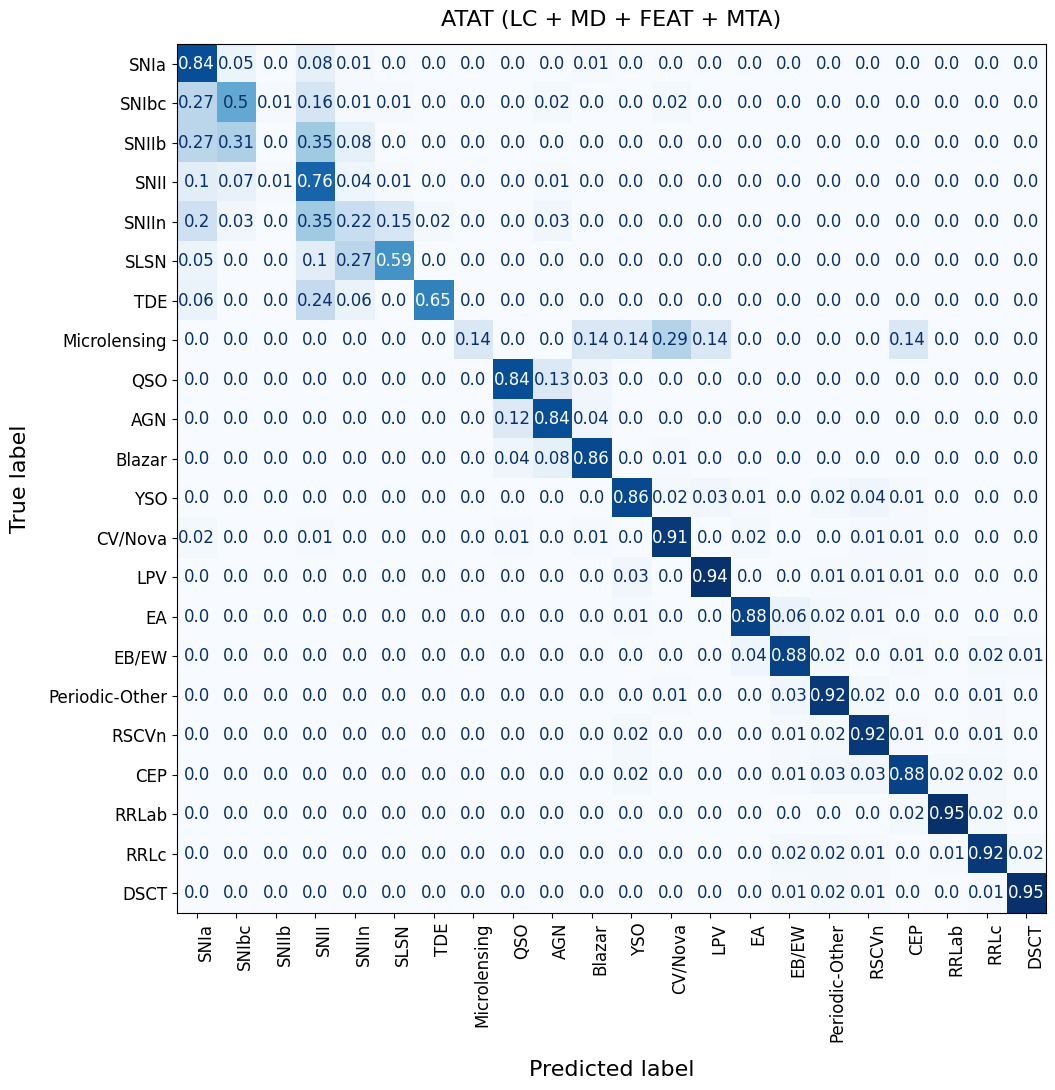

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7428290983207517